In [1]:
# Autoreload changed python modules
%load_ext autoreload

In [2]:
import os, glob
import h5py # for loading .h5 files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
import cs230_project_utilities as utils
# make sure you have pywt: pip3 install PyWavelets --user

# Loading the data

In [5]:
# Location of directory H5Exports_AnimiX/ (downloaded from Olivier's link)
dataset_directory = '/scratch/groups/mwinterm/BoostMRI/data/H5Exports_AnimiX'

In [6]:
# Find all the files in our dataset
h5_files = utils.automap.find_dataset_files(dataset_directory)

Found 133 .h5 files and 133 .txt files.


# Visualizing the data

In [7]:
##### Finally, we can see the raw data
h5 = h5_files['1497_18747']['h5']
h5_data = utils.automap.read_h5_file(h5)
print(h5_data.keys())

images = h5_data['images']
magnitude = h5_data['magnitude']
phase = h5_data['phase']
classification = h5_data['classification']

# (Note: shape of magnitude and phase are different from image)
print(images.shape, magnitude.shape, phase.shape)
print(np.ndarray.flatten(classification))

(15, 256, 256)
dict_keys(['classification', 'images', 'magnitude', 'phase'])
(15, 256, 256) (15, 256, 248) (15, 256, 248)
[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


/home/users/awal/.local/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [8]:
sample_index = np.argmax(classification)

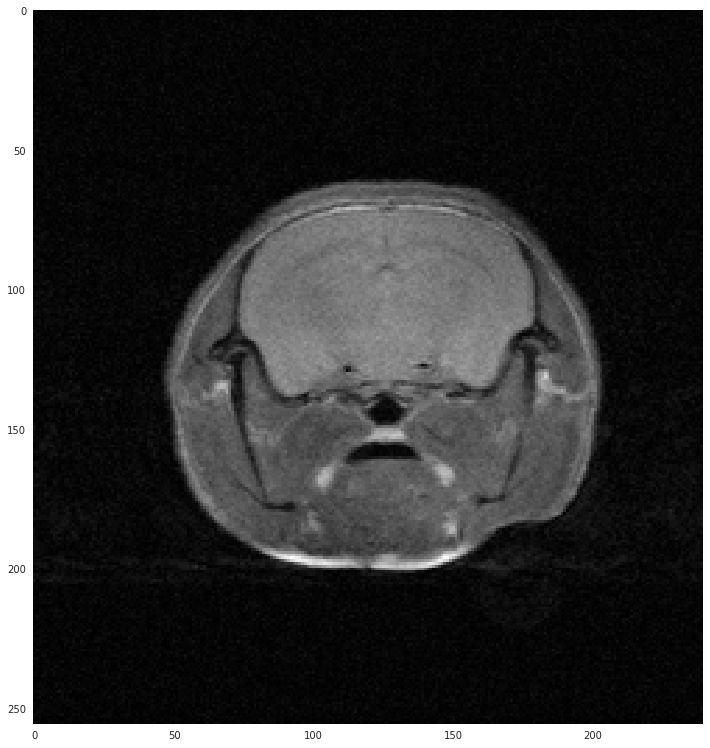

In [9]:
# Uncomment to view example image in dataset
utils.plot.imshowgray(utils.automap.transform_training_set_image_to_match_automap_output(images[sample_index]))

In [10]:
# Construct FFT (k-space data) from magnitude and phase
fft = magnitude[sample_index] * np.exp(1j * phase[sample_index])

# Take the inverse FFT
ifft = utils.signal_processing.ifft_2D_centered(fft)

# Note: shape of magnitude and phase are different from image.
# Because of this, the reconstruction shape is different from the
# image shape and so we can't compare the image and reconstruction directly.
# How will we solve this?

# This check to make sure we are correctly combining magnitude and phase to construct the full, complex-valued FFT.
print('Error in FFT magnitude: {}'.format(utils.signal_processing.mean_square_error(np.abs(fft), magnitude[sample_index])))
print('Error in FFT phase: {}'.format(utils.signal_processing.mean_square_error(np.angle(fft), phase[sample_index])))

Error in FFT magnitude: 2.784311932404735e-20
Error in FFT phase: 5.924749942430753e-05


/home/users/awal/cs230-project/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


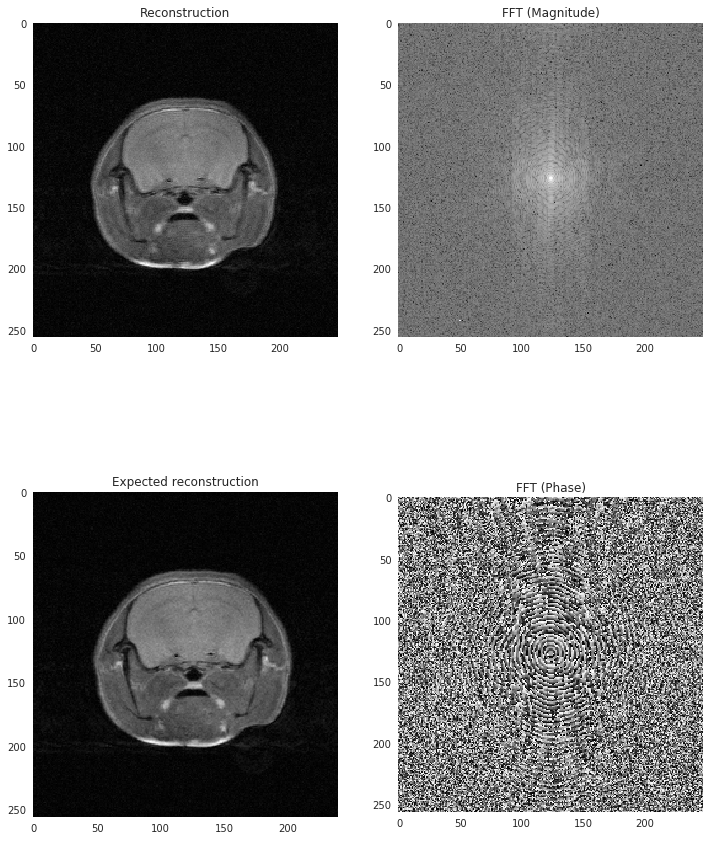

In [11]:
''' Uncomment to show plots.'''
plt.subplot(2, 2, 1)
plt.title('Reconstruction')
utils.plot.imshowgray(np.abs(ifft))
# 
plt.subplot(2, 2, 2)
plt.title('FFT (Magnitude)')
utils.plot.imshowfft(np.abs(fft))

plt.subplot(2, 2, 3)
plt.title('Expected reconstruction')
image = utils.automap.transform_training_set_image_to_match_automap_output(images[sample_index])
utils.plot.imshowgray(image)

plt.subplot(2, 2, 4)
plt.title('FFT (Phase)')
utils.plot.imshowgray(np.angle(fft))

# Automap Model

In [12]:
import tensorflow as tf

In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [14]:
import keras
from keras.layers import Input,Conv2D, Conv2DTranspose, Dense, Reshape, Flatten
from keras.models import Model
from keras.optimizers import RMSprop
from keras import losses

Using TensorFlow backend.


In [15]:
tf.reset_default_graph()

In [16]:
def load_model():
    n_H, n_W = 256, 240
    X = Input((n_H, n_W, 2))
    conv_downsample1 = Conv2D(1, 2, strides=2, activation='relu', padding='same')(X)
    conv_downsample2 = Conv2D(1, 2, strides=2, activation='relu', padding='same')(conv_downsample1)
    X1 = Flatten()(conv_downsample2)
    current_H, current_W = (64, 60) # after downsampling by 2 twice
    fc1 = Dense(current_H * current_W * 2, activation = 'tanh')(X1)
    fc2 = Dense(current_H * current_W, activation = 'tanh')(fc1)
    fc3 = Dense(current_H * current_W, activation = 'tanh')(fc2)
    X2 = Reshape((current_H, current_W, 1))(fc3)
    conv1_1 = Conv2D(64, 5, activation='relu', padding='same')(X2)
    conv1_2 = Conv2D(64, 5, activation='relu', padding='same')(conv1_1)
    conv1_3a = Conv2DTranspose(64, 9, activation='relu', padding='same')(conv1_2)
    conv1_3b = Conv2DTranspose(64, 9, strides=2, activation='relu', padding='same')(conv1_3a)
    conv1_3c = Conv2DTranspose(64, 9, strides=2, activation='relu', padding='same')(conv1_3b)
    out = Conv2D(1, 1, activation = 'linear',padding='same')(conv1_3c)
    model = Model(inputs=X, outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='mean_squared_error')
    return model

In [17]:
# # Original full model. Trainable params: 26,424,796,993.
# # (The 64 x 64 version has 117,892,929 params. Baseline has 74,843,087.)
# def load_model():
#     n_H, n_W = 256, 240 
#     X = Input((n_H, n_W, 2))
#     X1 = Flatten()(X)
#     fc1 = Dense(n_H * n_W * 2, activation = 'tanh')(X1)
#     fc2 = Dense(n_H * n_W, activation = 'tanh')(fc1)
#     fc3 = Dense(n_H * n_W, activation = 'tanh')(fc2)
#     X2 = Reshape((n_H, n_W, 1))(fc3)
#     conv1_1 = Conv2D(64, 5, activation='relu', padding='same')(X2)
#     conv1_2 = Conv2D(64, 5, activation='relu', padding='same')(conv1_1)
#     conv1_3 = Conv2DTranspose(64, 9, activation='relu', padding='same')(conv1_2)
#     out = Conv2D(1, 1, activation = 'linear',padding='same')(conv1_3)
#     model = Model(inputs=X, outputs=out)
#     model.compile(optimizer=RMSprop(lr=1e-5), loss='mean_squared_error') # different optimizer
#     return model

In [18]:
model = load_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 240, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 120, 1)       9         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 60, 1)         5         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7680)              29498880  
_________________________________________________________________
dense_2 (Dense)              (None, 3840)              29495040  
_________________________________________________________________
dens

In [19]:
def batch_generator():
    # Generate training batches by reading sequences from disk
    # Nothing special here, not even iterating randomly.
    
    # Find all the files in our dataset
    dataset_directory = '/scratch/groups/mwinterm/BoostMRI/data/H5Exports_AnimiX'
    h5_files = utils.automap.find_dataset_files(dataset_directory)[]
    
    batch_size = 4
    n_H, n_W = 256, 240
    
    X_batch = np.zeros((batch_size, n_H, n_W, 2))
    Y_batch = np.zeros((batch_size, n_H, n_W, 1))  

    current_batch_size = 0
    
    while True:
        for _, h5_file in h5_files.items():

            h5_data = utils.automap.read_h5_file(h5_file['h5'])

            image_sequence = h5_data['images']
            image_sequence = utils.automap.transform_training_set_image_to_match_automap_output(image_sequence)
            image_sequence = np.expand_dims(np.transpose(image_sequence, axes=(2, 0, 1)), axis=-1) # model expects 4 dims

            magnitude_sequence = h5_data['magnitude']
            phase_sequence = h5_data['phase']
            fft_sequence = np.concatenate((np.expand_dims(magnitude_sequence, axis=3),
                                  np.expand_dims(phase_sequence, axis=3)),
                                 axis=3)
            
            # NOTE: contains info on positive/negative samples, but don't do anything with this now.
            class_sequence = h5_data['classification'] 
            
            for i in range(len(fft_sequence)):
                try:
                    X_batch[current_batch_size, ...] = fft_sequence[i, ...]
                    Y_batch[current_batch_size, ...] = image_sequence[i, ...]
                except Exception as e:
                    print('Error making batch: {}'.format(e))

                current_batch_size += 1
                
                if current_batch_size == batch_size:
                    current_batch_size = 0
                    yield X_batch, Y_batch
                    

In [20]:
# With batch generator:

# Use first batch as validation data for now
X_development, Y_development = next(batch_generator())

sess = tf.Session(config=config)

Found 133 .h5 files and 133 .txt files.
(12, 256, 256)


/home/users/awal/.local/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [ ]:
model.load_weightsd_weightsd_weightsd_weightsd_weightsnt to resume training
# model.load_weights('automap_baseline.h5')

In [21]:
# Start training
with sess.as_default():
    fit_model = model.fit_generator(batch_generator(),
                                 validation_data=(X_development, Y_development),
                                 steps_per_epoch=8,
                                 epochs=25,
                                 verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
Found 133 .h5 files and 133 .txt files.
(12, 256, 256)
(15, 256, 256)


/home/users/awal/.local/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(15, 256, 256)
(15, 256, 256)
8/8 [==============================] - 76s 10s/step - loss: 0.0249 - val_loss: 0.0164
Epoch 2/25
8/8 [==============================] - 70s 9s/step - loss: 0.0127 - val_loss: 0.0098
Epoch 3/25
8/8 [==============================] - 70s 9s/step - loss: 0.0101 - val_loss: 0.0106
Epoch 4/25
8/8 [==============================] - 70s 9s/step - loss: 0.0094 - val_loss: 0.0090
Epoch 5/25
1/8 [==>...........................] - ETA: 58s - loss: 0.0091(15, 256, 256)
Error making batch: could not broadcast input array from shape (256,248,2) into shape (256,240,2)
Error making batch: could not broadcast input array from shape (256,248,2) into shape (256,240,2)
Error making batch: could not broadcast input array from shape (256,248,2) into shape (256,240,2)
2/8 [======>.......................] - ETA: 50s - loss: 0.0089Error making batch: could not broadcast input array from shape (256,248,2) into shape (256,240,2)
Error making batch: could not broadcast input array fr

8/8 [==============================] - 70s 9s/step - loss: 0.0146 - val_loss: 0.0085
Epoch 21/25
8/8 [==============================] - 70s 9s/step - loss: 0.0155 - val_loss: 0.0072
Epoch 22/25
8/8 [==============================] - 70s 9s/step - loss: 0.0089 - val_loss: 0.0111
Epoch 23/25
8/8 [==============================] - 70s 9s/step - loss: 0.0128 - val_loss: 0.0073
Epoch 24/25
(12, 256, 256)
8/8 [==============================] - 70s 9s/step - loss: 0.0102 - val_loss: 0.0071
Epoch 25/25
8/8 [==============================] - 70s 9s/step - loss: 0.0115 - val_loss: 0.0092


In [ ]:
model.save('automap_baseline.h5')

In [22]:
# Visualize predictions

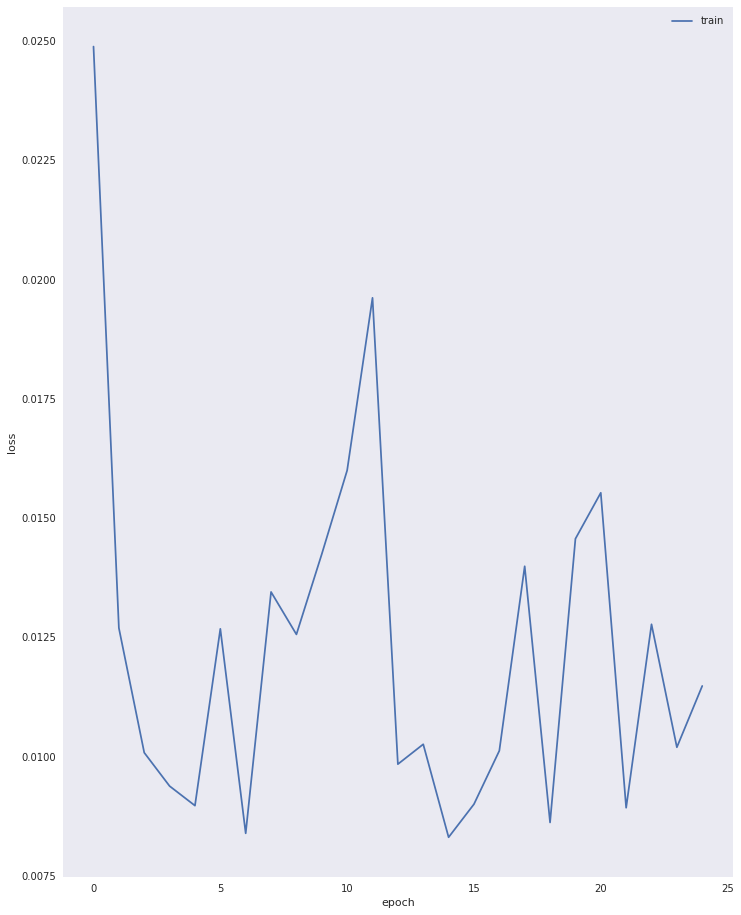

In [23]:
plt.plot(fit_model.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])

In [24]:
# Run predictions on development set
with sess.as_default():
    
    prediction_batch = model.predict(X_development)
    prediction_batch = prediction_batch.squeeze()
    
    ground_truth_batch = Y_development.squeeze()

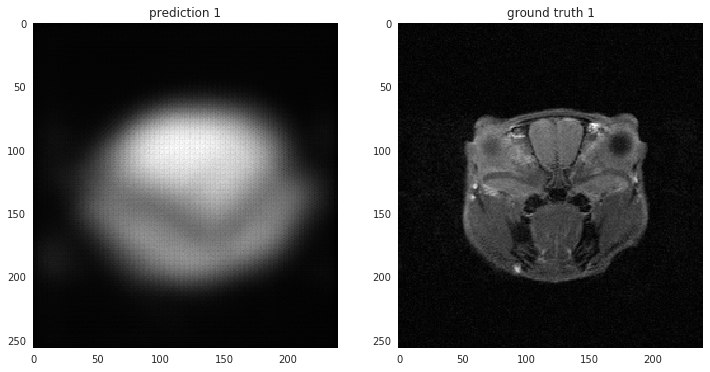

In [25]:
plt.rcParams['image.cmap'] = 'gray' # b/w images

# Prediction 1
plt.subplot(1, 2, 1)
plt.imshow(prediction_batch[0])
plt.title('prediction 1')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_batch[0])
plt.title('ground truth 1');

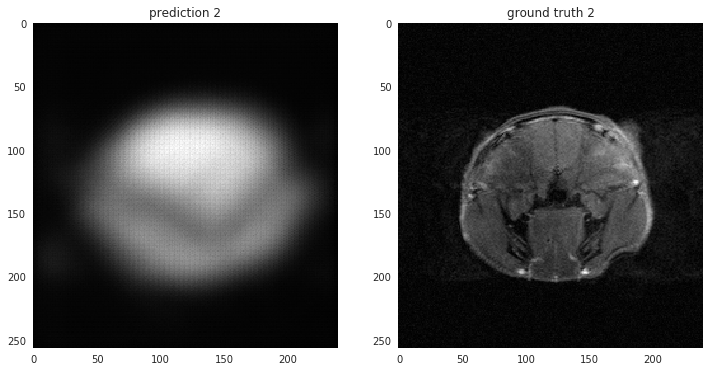

In [26]:
# Prediction 2
plt.subplot(1, 2, 1)
plt.imshow(prediction_batch[1])
plt.title('prediction 2')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_batch[1])
plt.title('ground truth 2');

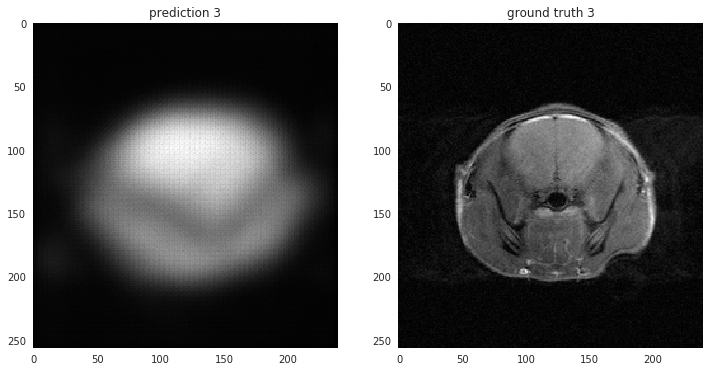

In [27]:
# Prediction 3
plt.subplot(1, 2, 1)
plt.imshow(prediction_batch[2])
plt.title('prediction 3')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_batch[2])
plt.title('ground truth 3');

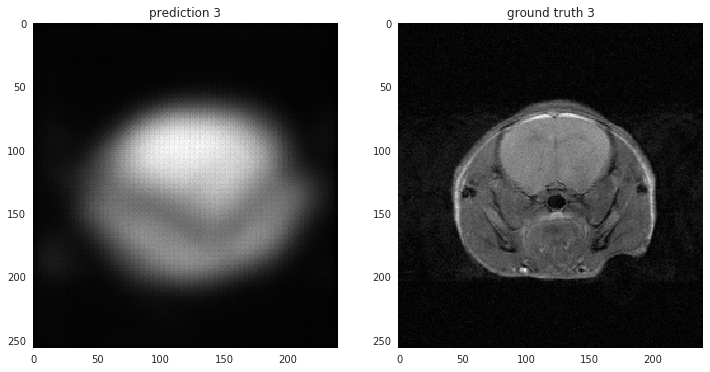

In [28]:
# Prediction 4
plt.subplot(1, 2, 1)
plt.imshow(prediction_batch[3])
plt.title('prediction 3')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_batch[3])
plt.title('ground truth 3');